<p align="center"><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true"></p><h1><font color='0B5345'> <center>

Probabilidad y estadística

 </center></font></h1>
<h2><font color='0B5345'> <center>
Tercer Proyecto: Aprendizaje Supervisado</center></font></h2>
<font  face="Courier New" size="3">

<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia - Bioingeniería</font></b> </center></p3>

### **MODELO DE CLASIFICACIÓN**

### **ANÁLISIS EXPLORATORIO DE DATOS**

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [163]:
df_cancer = pd.read_csv('data_cancer.csv', sep=";")
df_cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Intercambiamos;

Benigno (B) = 0

Maligno (M) = 1

In [164]:
df_cancer.replace(regex=r'B', value=0, inplace=True)
df_cancer.replace(regex=r'M', value=1, inplace=True)

In [165]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [166]:
df_cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
diagnosis,569.0,3.725835e-01,4.839180e-01,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01


En una inspección rápida, notamos que existen datos con valores iguales a 0. Estos datos no pueden existir ya que expresan medidas de volumen.

In [167]:
for column in df_cancer.columns:
    zero_values = (df_cancer[column] == 0).sum()
    if zero_values != 0:
        print(column, zero_values)

diagnosis 357
concavity_mean 13
concave points_mean 13
concavity_se 13
concave points_se 13
concavity_worst 13
concave points_worst 13


Viendo la poca cantidad de datos, decidimos quitarlos del dataset. Diagnosis no va a ser afectado.

In [168]:
df_cancer = df_cancer[(df_cancer.drop('diagnosis', axis=1) != 0).all(axis=1)]
len(df_cancer)

556

In [169]:
df_cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
id,556.0,3.104770e+07,1.263967e+08,8670.000000,869189.500000,906414.500000,8.910313e+06,9.113205e+08
diagnosis,556.0,3.812950e-01,4.861421e-01,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
radius_mean,556.0,1.423756e+01,3.482170e+00,7.691000,11.760000,13.455000,1.604000e+01,2.811000e+01
texture_mean,556.0,1.925975e+01,4.246993e+00,9.710000,16.177500,18.855000,2.173500e+01,3.928000e+01
perimeter_mean,556.0,9.273667e+01,2.400636e+01,48.340000,75.845000,87.090000,1.052500e+02,1.885000e+02
area_mean,556.0,6.637347e+02,3.508933e+02,170.400000,427.750000,557.650000,7.980500e+02,2.501000e+03
smoothness_mean,556.0,9.661649e-02,1.389530e-02,0.062510,0.086665,0.096035,1.054000e-01,1.634000e-01
compactness_mean,556.0,1.056788e-01,5.264255e-02,0.019380,0.066608,0.095090,1.306000e-01,3.454000e-01
concavity_mean,556.0,9.087556e-02,7.946754e-02,0.000692,0.030880,0.064905,1.323250e-01,4.268000e-01
concave points_mean,556.0,5.006294e-02,3.851706e-02,0.001852,0.020895,0.034840,7.484250e-02,2.012000e-01


Para facilitar la visualización de los datos aplicamos z-score a todas las columnas

In [170]:
df_cancer_z = df_cancer.drop(['diagnosis'], axis=1)
df_cancer_z = (df_cancer_z - df_cancer_z.mean()) / df_cancer_z.std()

<Axes: >

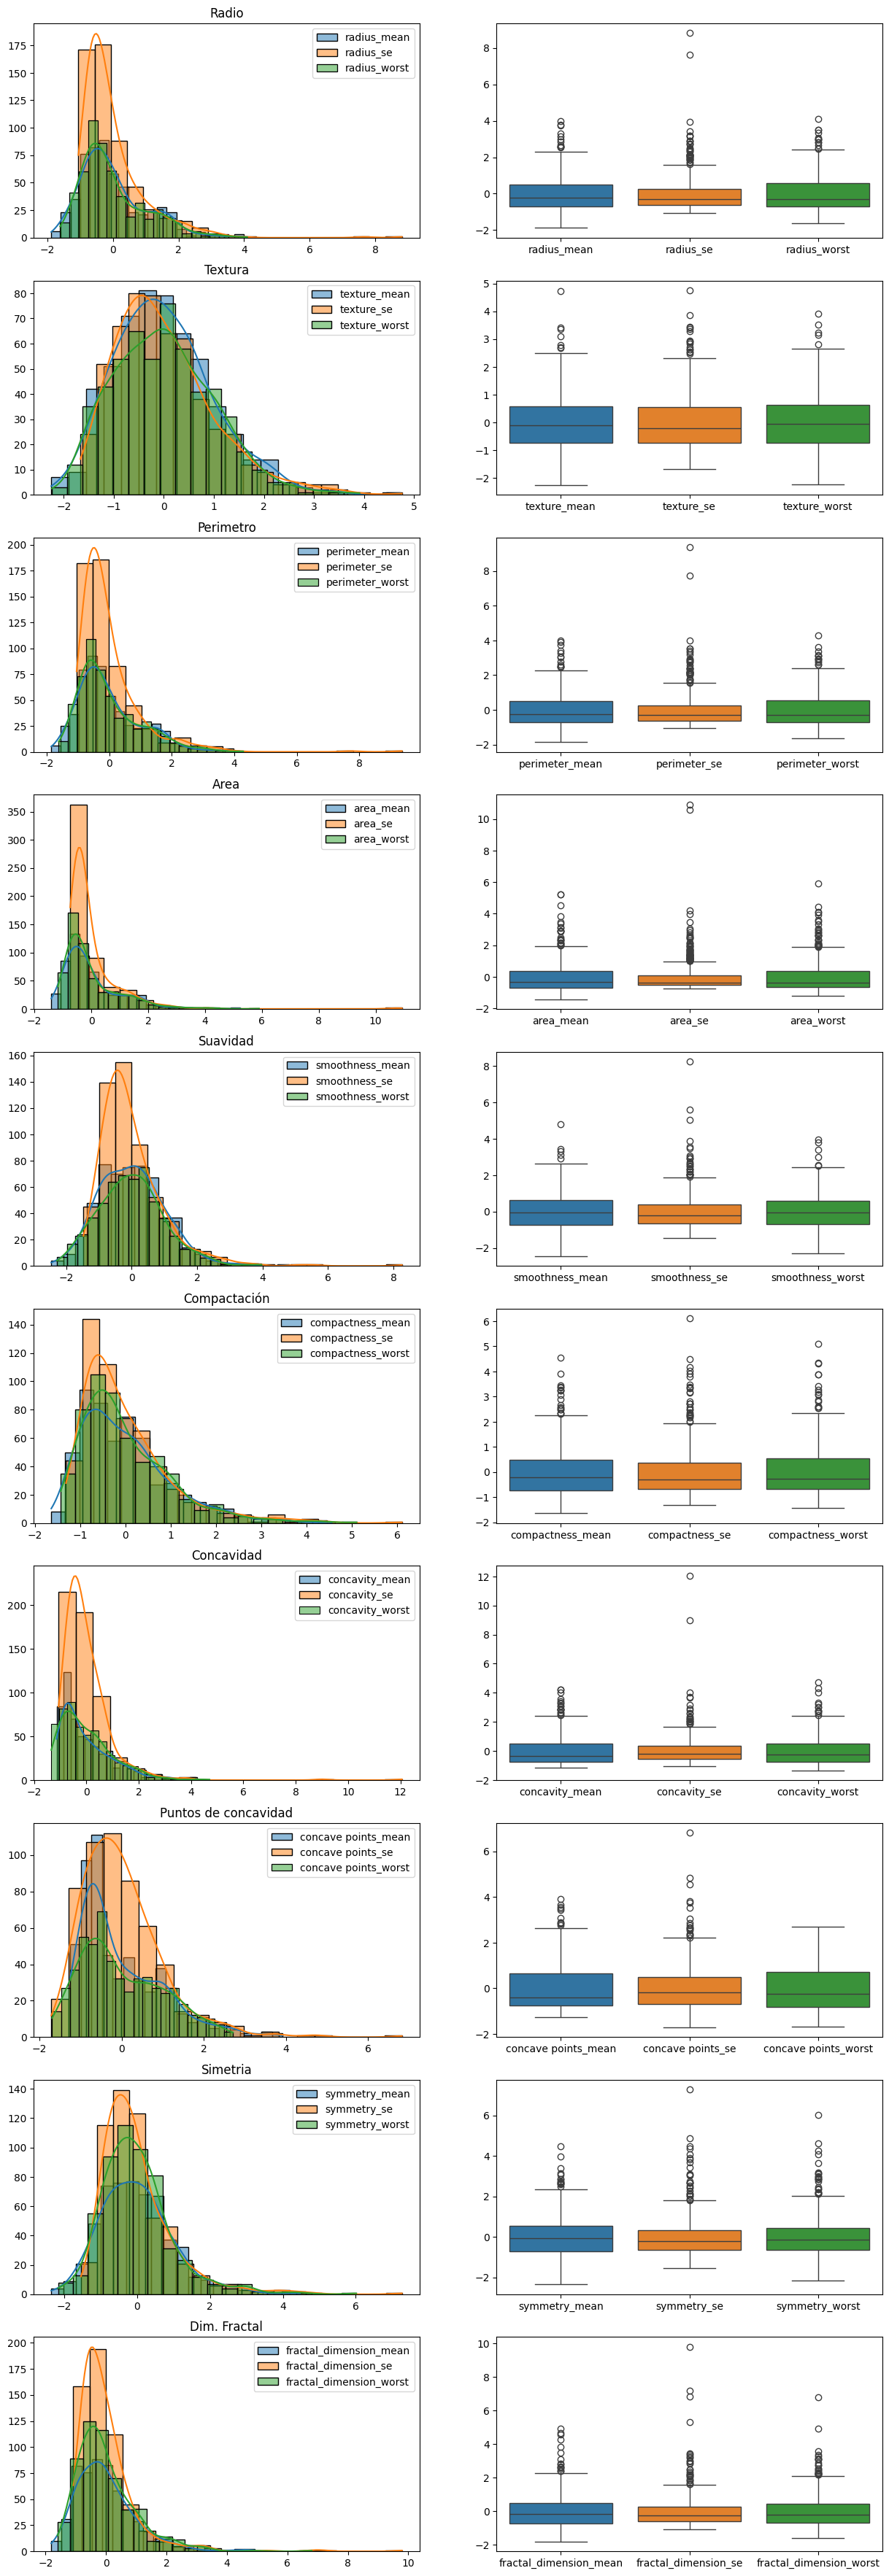

In [171]:
fig, axs = plt.subplots(10, 2, figsize=(15, 45))

# Histogramas

def hist_cancer(columna, ax1, name):
    for a in columna:
        sns.histplot(data=df_cancer_z, x=a, bins=20, kde=True, ax=ax1, label=a)
    ax1.legend()
    ax1.set_title(name)
    ax1.set_xlabel('')
    ax1.set_ylabel('')

radio = ['radius_mean', 'radius_se', 'radius_worst']
textura = ['texture_mean', 'texture_se', 'texture_worst']
perimetro = ['perimeter_mean', 'perimeter_se', 'perimeter_worst']
area = ['area_mean', 'area_se', 'area_worst']
suavidad = ['smoothness_mean', 'smoothness_se', 'smoothness_worst']
compactacion = ['compactness_mean', 'compactness_se', 'compactness_worst']
concavidad = ['concavity_mean', 'concavity_se', 'concavity_worst']
pts_concavidad = ['concave points_mean', 'concave points_se', 'concave points_worst']
simetria = ['symmetry_mean', 'symmetry_se', 'symmetry_worst']
dim_frac = ['fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_worst']

hist_cancer(radio, axs[0, 0], 'Radio')
hist_cancer(textura, axs[1, 0], 'Textura')
hist_cancer(perimetro, axs[2, 0], 'Perimetro')
hist_cancer(area, axs[3, 0], 'Area')
hist_cancer(suavidad, axs[4, 0], 'Suavidad')
hist_cancer(compactacion, axs[5, 0], 'Compactación')
hist_cancer(concavidad, axs[6, 0], 'Concavidad')
hist_cancer(pts_concavidad, axs[7, 0], 'Puntos de concavidad')
hist_cancer(simetria, axs[8, 0], 'Simetria')
hist_cancer(dim_frac, axs[9, 0], 'Dim. Fractal')

sns.boxplot(data=df_cancer_z[radio], ax=axs[0, 1])
sns.boxplot(data=df_cancer_z[textura], ax=axs[1, 1])
sns.boxplot(data=df_cancer_z[perimetro], ax=axs[2, 1])
sns.boxplot(data=df_cancer_z[area], ax=axs[3, 1])
sns.boxplot(data=df_cancer_z[suavidad], ax=axs[4, 1])
sns.boxplot(data=df_cancer_z[compactacion], ax=axs[5, 1])
sns.boxplot(data=df_cancer_z[concavidad], ax=axs[6, 1])
sns.boxplot(data=df_cancer_z[pts_concavidad], ax=axs[7, 1])
sns.boxplot(data=df_cancer_z[simetria], ax=axs[8, 1])
sns.boxplot(data=df_cancer_z[dim_frac], ax=axs[9, 1])

Remoción de datos atípicos

In [172]:
def remove_outliers_iqr(data):
    
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    data = np.where(data>upper_bound, upper_bound, np.where(data<lower_bound,lower_bound,data))
    return data[(data >= lower_bound) & (data <= upper_bound)]

In [173]:
for i in df_cancer.columns:
    df_cancer[i] = remove_outliers_iqr(df_cancer[i])

C:\Users\jjcor\AppData\Local\Temp\ipykernel_29336\3338917969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer[i] = remove_outliers_iqr(df_cancer[i])


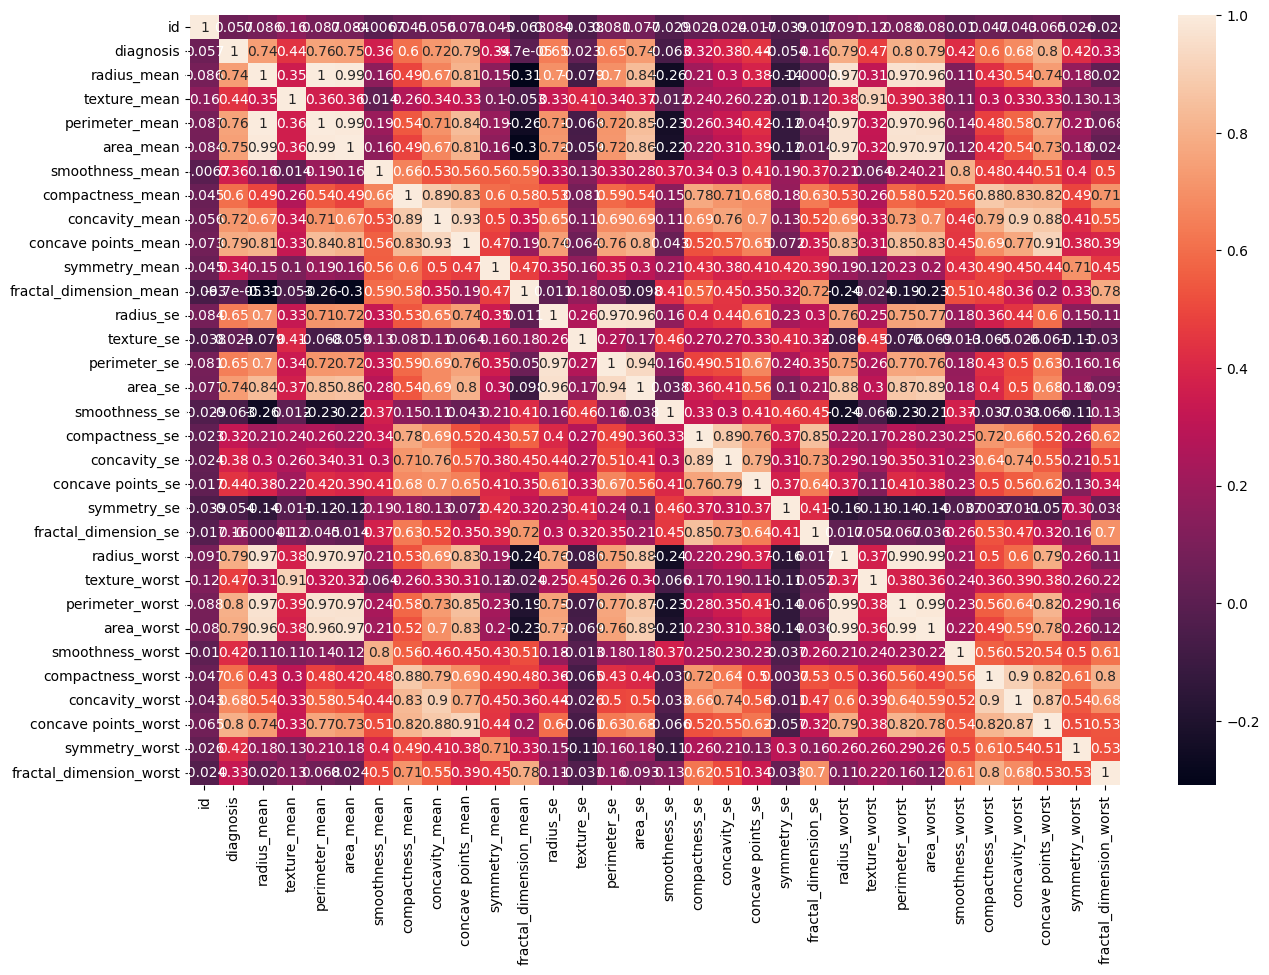

In [174]:
plt.figure(figsize=(15,10))
sns.heatmap(df_cancer.corr(),fmt='.2g',annot=True)
plt.show()

> Una primera observación a destacar es la fuerte correlación del radio, perímetro y área de la imagen, debido a que el área es la que aporta más información, elegimos las columnas relacionadas para nuestro modelo.


> El segundo aspecto a destacar son las correlaciones entre las medias de todos los datos y su peor valor registrado, si bien no tan significatico como el punto anterior, sigue teniendo una influencia significativa con valores de hasta 0.8. Se decidió por la media por aportar más información.

Así despues de una purga de columnas obtenemos:

In [175]:
df_cancer_test =  df_cancer[['diagnosis', 
                            'area_mean', 'area_se',
                            'smoothness_mean', 'smoothness_se',
                            'compactness_mean', 'compactness_se',
                            'concavity_mean', 'concavity_se',
                            'concave points_mean', 'concave points_se',
                            'symmetry_mean', 'symmetry_se',
                            'fractal_dimension_mean', 'fractal_dimension_se']]

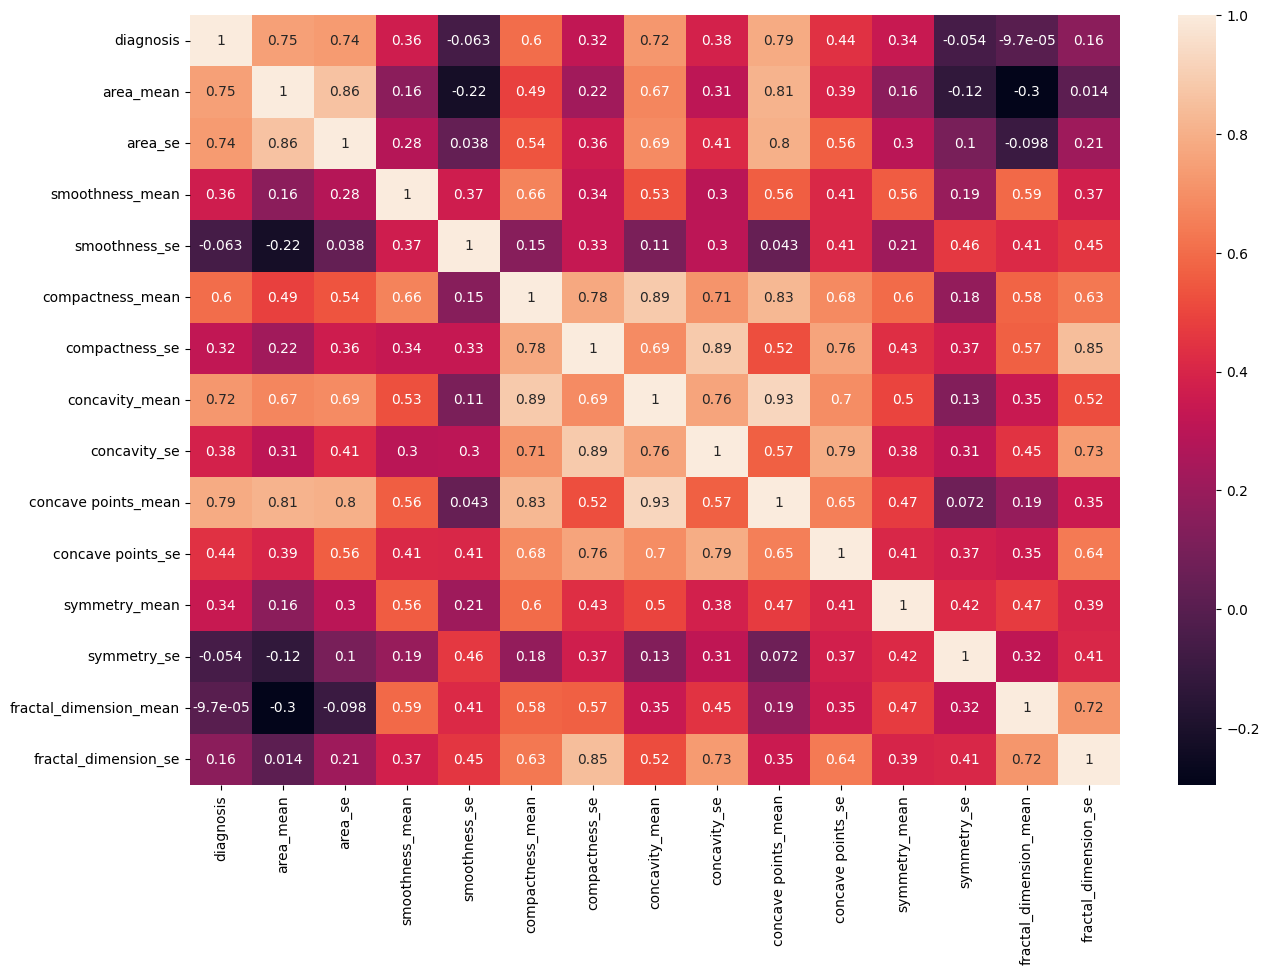

In [176]:
plt.figure(figsize=(15,10))
sns.heatmap(df_cancer_test.corr(),fmt='.2g',annot=True)
plt.show()

En este segundo análisis de datos; 

> notemos que la concavidad y los puntos de concavidad siguen fuertemente relacionados entre sí, elegimos los puntos de concavidad debido a que presenta una mayor correlación con el diagnóstico.

> Lo mismo sucede con la compactación, por este motivo se elige solo los puntos de concavidad.

> Además por la poca correlación que ejerce la dimensión fractal, se decidió prescindir de esta columna.

In [177]:
df_cancer_test =  df_cancer[['diagnosis', 
                            'area_mean', 'area_se',
                            'smoothness_mean', 'smoothness_se',
                            'concave points_mean', 'concave points_se',
                            'symmetry_mean', 'symmetry_se']]

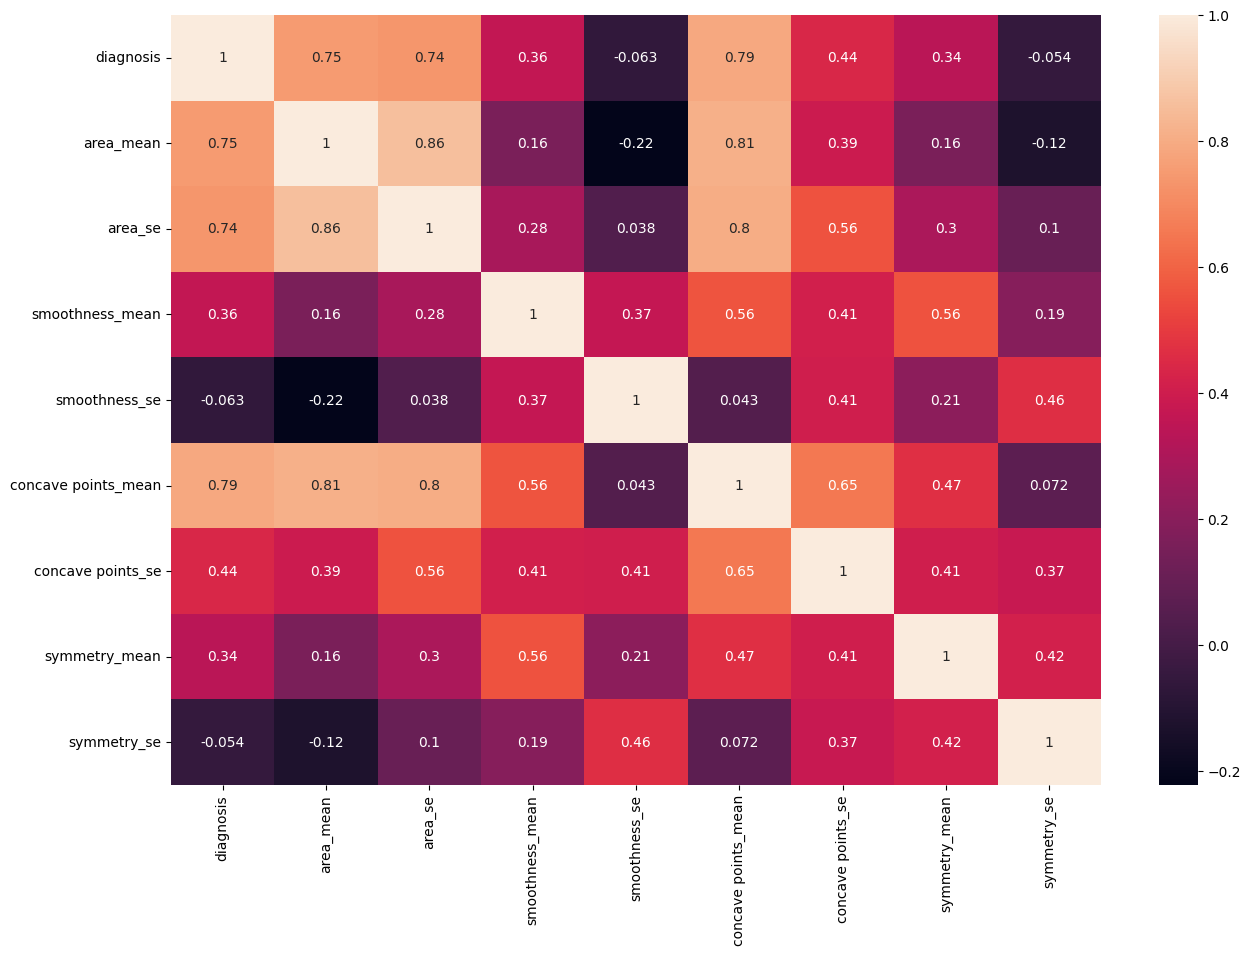

In [178]:
plt.figure(figsize=(15,10))
sns.heatmap(df_cancer_test.corr(),fmt='.2g',annot=True)
plt.show()

In [179]:
df_cancer_test

,diagnosis,area_mean,area_se,smoothness_mean,smoothness_se,concave points_mean,concave points_se,symmetry_mean,symmetry_se
0,1.0,1001.0,86.81375,0.118400,0.006399,0.14710,0.015870,0.241900,0.03003
1,1.0,1326.0,74.08000,0.084740,0.005225,0.07017,0.013400,0.181200,0.01389
2,1.0,1203.0,86.81375,0.109600,0.006150,0.12790,0.020580,0.206900,0.02250
3,1.0,386.1,27.23000,0.133502,0.009110,0.10520,0.018670,0.246525,0.03482
4,1.0,1297.0,86.81375,0.100300,0.011490,0.10430,0.018850,0.180900,0.01756
...,...,...,...,...,...,...,...,...,...
563,1.0,1347.0,86.81375,0.109900,0.006399,0.14740,0.025337,0.214900,0.02057
564,1.0,1353.5,86.81375,0.111000,0.010300,0.13890,0.024540,0.172600,0.01114
565,1.0,1261.0,86.81375,0.097800,0.005769,0.09791,0.016780,0.175200,0.01898
566,1.0,858.1,48.55000,0.084550,0.005903,0.05302,0.015570,0.159000,0.01318


**Variables**:

**Explicada (Y)**: 
- Diagnostico(tumor benigno o no maligno)

**Explicatorias (X)**: 
- area_mean 
- area_se
- smoothness_mean 
- smoothness_se
- concave points_mean
- concave points_se
- symmetry_mean 
- symmetry_se
- fractal_dimension_mean
- fractal_dimension_se

Importamos las librerias

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [181]:
x = df_cancer_test.drop(columns=['diagnosis'])

y = df_cancer_test['diagnosis']

Datos de entrenamiento

In [182]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

Entrenamiento del modelo

In [183]:
modelo = LogisticRegression(max_iter= 1000)
modelo.fit(x_train, y_train)

y_predi = modelo.predict(x_test)

Matriz de confusion

Text(0.5, 23.52222222222222, 'Valores reales')

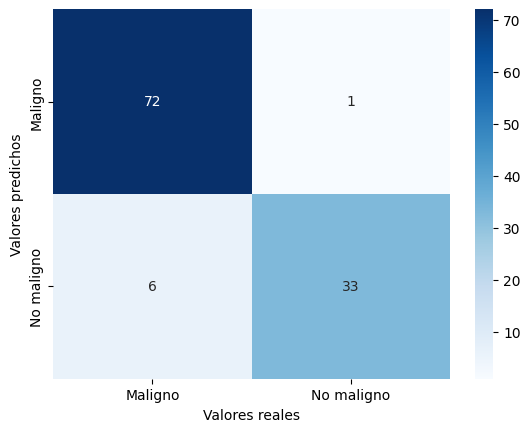

In [184]:
matriz_confusion = confusion_matrix(y_test, y_predi)

# Heatmap
sns.heatmap(matriz_confusion, annot= True, fmt= 'd', cmap= 'Blues',
            xticklabels= ['Maligno', 'No maligno'],
            yticklabels= ['Maligno', 'No maligno'])

plt.ylabel('Valores predichos')
plt.xlabel('Valores reales')